In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.stats import shapiro

In [102]:
df = pd.read_csv('./historicalData/processed_btc_data.csv', parse_dates=['snapped_at'])
df.set_index('snapped_at', inplace=True)  # Set 'Date' as the index
log_returns = df['log_returns']

In [103]:
# Step 1: Set GARCH(1,1) parameters 
alpha0 = 0.000001 #long-run average variance
alpha1 = 0.08 #captures the impact of past squared returns
beta1  = 0.9 #captures the persistence of volatility

In [104]:
# Step 2: Create arrays to store conditional variances and residuals
n = len(df)
sigma2 = np.zeros(n)
epsilon = log_returns - np.mean(log_returns)  # Residuals (demeaned returns)

In [105]:
# Step 3: Initialize sigma² with the unconditional variance
sigma2[0] = np.var(log_returns)

In [106]:
# Step 4: Recursive GARCH formula
for t in range(1, n):
    sigma2[t] = alpha0 + alpha1 * epsilon.iloc[t-1]**2 + beta1 * sigma2[t-1]

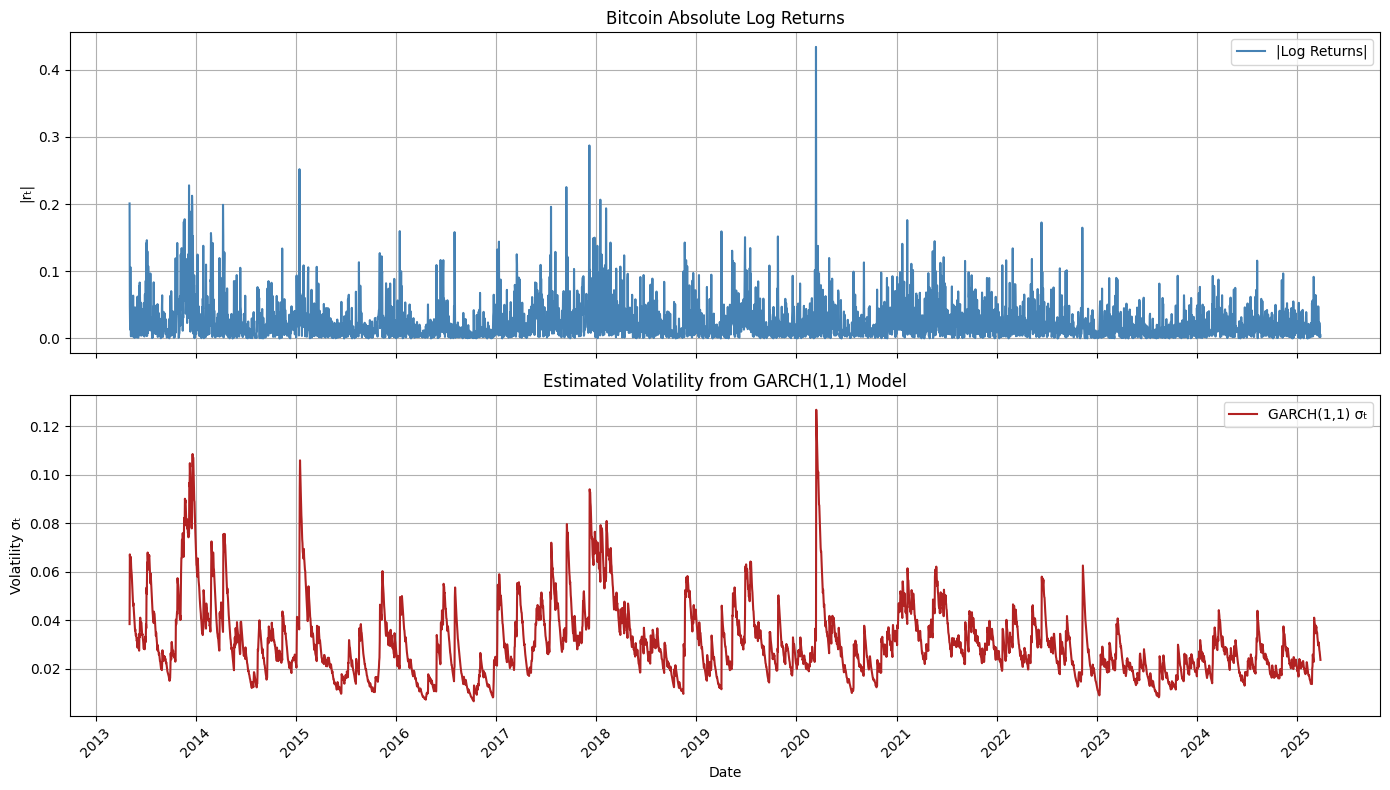

In [107]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# Create a figure with 2 vertical subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Subplot 1: Log returns (absolute value)
axs[0].plot(log_returns.index, np.abs(log_returns), color='steelblue', label='|Log Returns|')
axs[0].set_title("Bitcoin Absolute Log Returns")
axs[0].set_ylabel("|rₜ|")
axs[0].grid(True)
axs[0].legend(loc='upper right')

# Subplot 2: GARCH(1,1) Estimated Volatility
axs[1].plot(log_returns.index, np.sqrt(sigma2), color='firebrick', label='GARCH(1,1) σₜ')
axs[1].set_title("Estimated Volatility from GARCH(1,1) Model")
axs[1].set_ylabel("Volatility σₜ")
axs[1].set_xlabel("Date")
axs[1].grid(True)
axs[1].legend(loc='upper right')

# Format x-axis ticks as years
axs[1].xaxis.set_major_locator(mdates.YearLocator())
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

<Figure size 1000x500 with 0 Axes>

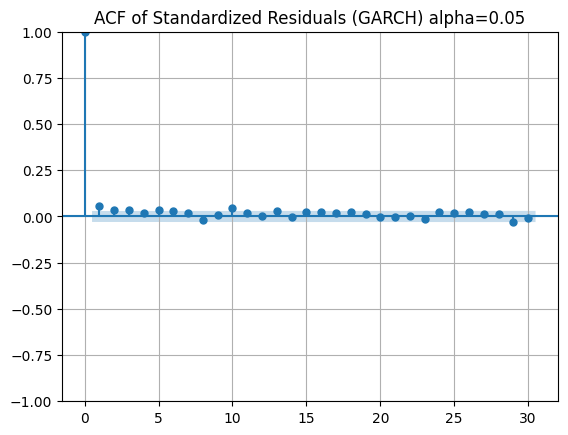

In [108]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf

# ACF est whith hand-made model 
standardized_residuals = (log_returns - log_returns.mean()) / np.sqrt(sigma2)
z = pd.Series(standardized_residuals, index=df.index)


# Plot ACF of standardized residuals
plt.figure(figsize=(10, 5))
plot_acf(z, lags=30, alpha=0.05)  # alpha=0.05 → 95% confidence interval
plt.title("ACF of Standardized Residuals (GARCH) alpha=0.05")
plt.grid(True)
plt.show()

In [109]:
# Student-t vs GARCH chi-squared test

In [110]:
from scipy.stats import t

# Fit t-distribution to the data

params = t.fit(log_returns)
loglik_t = np.sum(t.logpdf(log_returns, *params))
print("Log-likelihood of the t-student:", loglik_t)

Log-likelihood of the t-student: 8705.525152539387


In [111]:
from arch import arch_model

model = arch_model(log_returns, vol='GARCH', p=1, q=1, dist='t', rescale=False)

# Fit the GARCH(1,1) model with Student's t errors
model_fit = model.fit()

# Extract the log-likelihood from the fit results
ll_garch = model_fit.loglikelihood

print("Log-likelihood of the GARCH(1,1) model:", ll_garch)
# Print all estimated parameters
print("\nEstimated Parameters:")
print(model_fit.params)

Iteration:      1,   Func. Count:      7,   Neg. LLF: 81505.22252662713
Iteration:      2,   Func. Count:     23,   Neg. LLF: 94464.34554647846
Iteration:      3,   Func. Count:     39,   Neg. LLF: 4451288.4298532605
Iteration:      4,   Func. Count:     55,   Neg. LLF: 16600.416161543948
Iteration:      5,   Func. Count:     65,   Neg. LLF: 16600.77857973923
Iteration:      6,   Func. Count:     71,   Neg. LLF: 17864.474815190057
Iteration:      7,   Func. Count:     78,   Neg. LLF: 16380.875258750668
Iteration:      8,   Func. Count:     87,   Neg. LLF: -569.1451043570412
Iteration:      9,   Func. Count:     93,   Neg. LLF: -3550.6762285317054
Iteration:     10,   Func. Count:     99,   Neg. LLF: 323983.7655771278
Iteration:     11,   Func. Count:    115,   Neg. LLF: 36527.688148935995
Iteration:     12,   Func. Count:    122,   Neg. LLF: 66993.68642939371
Iteration:     13,   Func. Count:    129,   Neg. LLF: 57010.483309218645
Iteration:     14,   Func. Count:    136,   Neg. LLF: 5

In [112]:
from scipy.stats import t, chi2

# Step 3: Likelihood Ratio Test
LR_stat = -2 * (loglik_t - ll_garch)
df = 2  # GARCH adds (alpha and beta) to the 3 parameters of Student-t
p_value = 1 - chi2.cdf(LR_stat, df)

# Step 4: Output
print(f"Likelihood Ratio Statistic: {LR_stat:.4f}")
print(f"P-value (scientific notation): {p_value:.2e}")

if p_value < 0.05:
    print("✅ GARCH(1,1) provides a significantly better fit than Student-t alone.")
else:
    print("❌ No strong evidence that GARCH(1,1) improves over Student-t.")

Likelihood Ratio Statistic: 91.6224
P-value (scientific notation): 0.00e+00
✅ GARCH(1,1) provides a significantly better fit than Student-t alone.


In [113]:
# Ljung box test
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(model_fit.std_resid, lags=[10], return_df=True)
print(lb_test)
# Interpret the result
if p_value < 0.05:
    print("❌ Residuals are significantly autocorrelated — model may be misspecified.")
else:
    print("✅ No significant autocorrelation — model appears well specified.")

      lb_stat  lb_pvalue
10  27.572533   0.002113
❌ Residuals are significantly autocorrelated — model may be misspecified.
